# Purpose

This notebook is to test whether the `neuro_op` module's nodes can successfully infer `world_dist` if only this distribution's information pieces $x_{world}$ are received (i.e., with rates h>0, r=0).

For this, the model is run with nodes receiving different amount of information (i.e., different `t_max`, `h`). Then, each node's posterior predictive distribution (*PPD*), equalling its forecast of future incoming information, is obtained via 
1. sampling of model parameters $\theta$ proportional to its posterior $p(\theta | x_{world})$;
2. using these sampled model parameters to generate data proportional to the model likelihood $p(x_{PPD}|\theta_{sampled})$

PPDs thereby fully conserves uncertainty by paying respect to both posterior and likelihood stochasticity.

We then use the PPDs to quantify the nodes' modelling accuracy by computing the Kullback-Leibler divergence and average MLE distances between node PPDs and data generated by `world_dist`.

In [2]:
import neuro_op as nop

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.stats as st

In [3]:
# Reference input for 'run_model' function. For description of contents, see 'run_model' function docstring.
input = dict(
    G=nop.build_random_network(N_nodes=100, N_neighbours=5),
    # networkx graph object
    llf_nodes=st.norm,  # Likelihood function (llf) of nodes, Gaussian by default
    llf_world=st.norm,  # Likelihood function (llf) of to-be-approximated world state, Gaussian by default
    params_node=dict(  # Likelihood function (llf) parameters of nodes, Gaussian by default
        loc=0,
        scale=1,
    ),
    params_world=dict(  # Likelihood function (llf) parameters of to-be-approximated world state, Gaussian by default
        loc=0,
        scale=1,
    ),
    beliefs=np.linspace(  # beliefs considered by each node
        start=-10,  # min. considered belief value
        stop=10,  # max. considered belief value
        num=500,  # number of considered belief values
    ),
    log_priors=np.zeros(500),  # Prior log-probabilities of nodes
    # Dynamics parameters (rates, simulation times)...
    h=1,
    r=1,
    t0=0,
    t_max=20,
    # Sampling parameters...
    t_sample=1,
    sample_bins=100,
    sample_range=(-10, 10),
    p_distance_params=[(1, 1), (2, 1)],
    # Switches...
    progress=False,
)

In [4]:
out1 = nop.run_model_Grid(**input)

print(out1["N_events"])

/home/jfriedel/Documents/Repos/neuro_op/src/neuro_op/neuro_op.py:290: RuntimeWarning: invalid value encountered in divide
  Q = Q / np.sum(Q)
/home/jfriedel/Documents/Repos/neuro_op/src/neuro_op/neuro_op.py:295: RuntimeWarning: divide by zero encountered in log
  terms = P * np.log(P / Q)
/home/jfriedel/Documents/Repos/neuro_op/src/neuro_op/neuro_op.py:295: RuntimeWarning: invalid value encountered in multiply
  terms = P * np.log(P / Q)


4007


In [5]:
def genf(dist, params):
    return dist(**params)


foo = genf(st.norm, dict(loc=0, scale=5))
foo.logpdf(range(10))

array([-2.52837645, -2.54837645, -2.60837645, -2.70837645, -2.84837645,
       -3.02837645, -3.24837645, -3.50837645, -3.80837645, -4.14837645])

In [6]:
# t_s =   0.2    -- 8.79
# t_s =   1.0    -- 5.32
# t_s =   2.0    -- 5.88
# t_s =   4.0    -- 5.15
# t_s > t_max    -- 4.79

In [19]:
nop.export_hdf5_Grid(out1, "test.h5")
out_1 = nop.import_hdf5_Grid("test.h5")

## Data analysis

Random data analysis test notebook of steps later used in thorough analysis.


In [20]:
# For improving of readability, increase all font sizes of plots. Also, set legend location to upper right.
plt.rcParams.update(
    {
        "font.size": 20,
        "legend.loc": "upper right",
    }
)

#### Data analysis 1

Firstly, extract output values for further analysis:

In [21]:
for i in out1.keys():
    print(i)

nodes
G
beliefs
world
N_events
t_end
mu_nodes
kl_divs
p_distances
seed



Each node's posteriors are plotted. One should see nodes' posteriors of model parameters (in this case, $\mu$), to converge around the true value. If not, nodes may need more information to converge ($\rightarrow$ increase $t_{max}, h$).


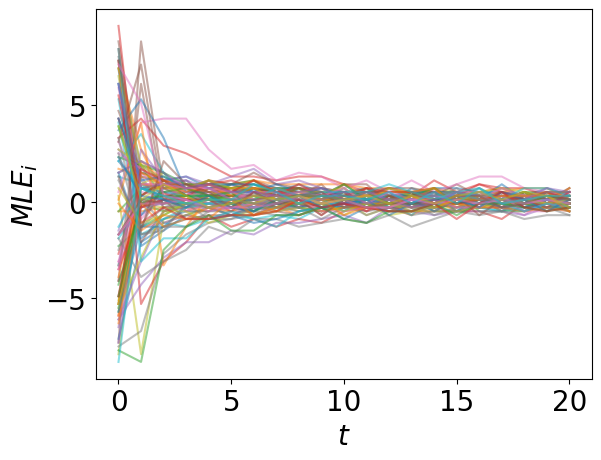

In [24]:
mu_arr = np.array(out1["mu_nodes"])
x = np.arange(input["t0"], input["t_max"] + input["t_sample"], input["t_sample"])
for i in range(len(mu_arr.T)):
    plt.plot(x, mu_arr.T[i], alpha=0.5, label=f"Node {i}")
    plt.xlabel("$t$")
    plt.ylabel("$MLE_i$")

#### Data analysis 2

In [25]:
N_iter = range(input["G"].number_of_nodes())
kld = np.array(out1["kl_divs"])
lin_dis = np.array(out1["p_distances"])[:, 0]
quad_dis = np.array(out1["p_distances"])[:, 1]
print(lin_dis.shape)
kld.shape
np.array(out1["p_distances"]).shape

(21, 2, 100)


(21, 2, 2, 100)

(21, 2)

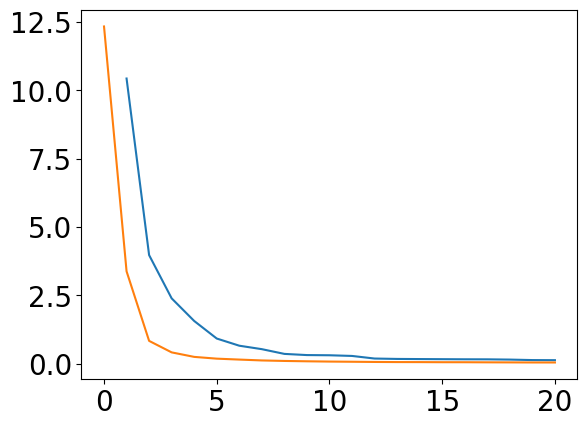

In [26]:
# for i in N_iter:
#    plt.plot(input["t_sample"] * np.arange(0, kld.shape[0]), kld[:, i, ])


i = 1
plt.plot(
    # input["t_sample"] * np.arange(0, kld.shape[0]),
    kld.mean(axis=i),
    label="avg",
)
kld.mean(axis=i).shape

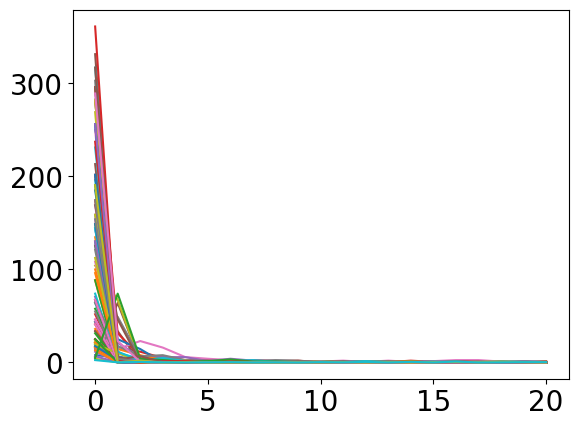

In [27]:
for i in N_iter:
    plt.plot(input["t_sample"] * np.arange(0, quad_dis.shape[0]), quad_dis[:, 0, i])

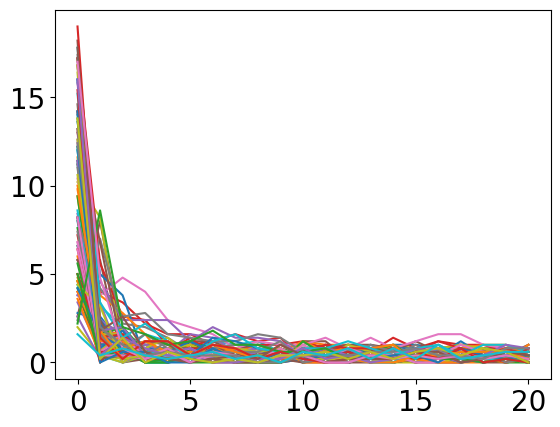

In [28]:
for i in N_iter:
    plt.plot(input["t_sample"] * np.arange(0, lin_dis.shape[0]), lin_dis[:, 0, i])